In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from PIL import Image

In [10]:
source = 'data'

train_imgs_path = os.path.join(source, 'train/images')
train_lbls_path = os.path.join(source, 'train/labels')

test_imgs_path = os.path.join(source, 'test/images')
test_lbls_path = os.path.join(source, 'test/labels')

val_imgs_path = os.path.join(source, 'valid/images')
val_lbls_path = os.path.join(source, 'valid/labels')

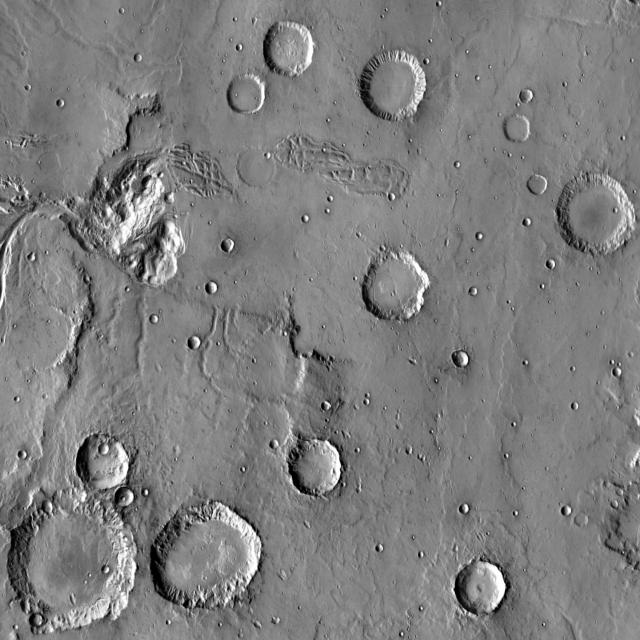

In [11]:
## Open a sample image
image_name = os.listdir(train_imgs_path)[0]
img = Image.open(os.path.join(train_imgs_path, image_name))

img

In [12]:
def load_labels(label_path):
    label_files = os.listdir(label_path)
    data = []
    classes = set()
    for file in label_files:
        with open(os.path.join(label_path, file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                box_info = list(map(float, line.strip().split()))
                data.append([file, *box_info])
                class_id = box_info[0]
                classes.add(int(class_id))
    df = pd.DataFrame(data, columns=['file', 
                                     'class_id', 
                                     'center_x',
                                     'center_y',
                                     'width',
                                     'height'
                                    ])
    return df, sorted(classes)

train_labels, train_classes = load_labels(train_lbls_path)
val_labels, val_classes = load_labels(val_lbls_path)
test_labels, test_classes = load_labels(test_lbls_path)

In [13]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   file      681 non-null    object 
 1   class_id  681 non-null    float64
 2   center_x  681 non-null    float64
 3   center_y  681 non-null    float64
 4   width     681 non-null    float64
 5   height    681 non-null    float64
dtypes: float64(5), object(1)
memory usage: 32.1+ KB


In [14]:
train_labels.head()

,file,class_id,center_x,center_y,width,height
0,mars_crater--110-_jpg.rf.593f6a3d9aed98e7a0895...,0.0,0.325781,0.416406,0.230469,0.354687
1,mars_crater--43-_jpg.rf.27ea7a65603205e491bc43...,0.0,0.384375,0.480469,0.054688,0.083594
2,mars_crater--43-_jpg.rf.27ea7a65603205e491bc43...,0.0,0.410938,0.087500,0.039844,0.057031
3,mars_crater--24-_jpg.rf.4614bb6844fda70ea8a3b4...,0.0,0.517969,0.499219,0.891406,0.998437
4,mars_crater--118-_jpg.rf.0a8b3fb0e1332e576901e...,0.0,0.675781,0.082031,0.040625,0.052344


In [15]:
def plot_bb_dist(labels, title):
    labels['area'] = labels['width'] * labels['height']
    fig = px.histogram(labels, x='area', nbins=40, title=title)
    fig.show()

def plot_width_and_height_dist(labels):
    fig = px.histogram(labels, x='width', nbins=40, title='Width Distribution of the above data')
    fig2 = px.histogram(labels, x='height', nbins=40, title='Height Distribution of the above data')
    fig.show()
    fig2.show()
    

plot_bb_dist(train_labels, 'Train Bounding Box Area Distribution')
plot_width_and_height_dist(train_labels)
plot_bb_dist(val_labels, 'Validation Bounding Box Area Distribution')
plot_width_and_height_dist(val_labels)
plot_bb_dist(test_labels, 'Test Bounding Box Area Distribution')
plot_width_and_height_dist(test_labels)

In [16]:
def plot_aspect_rt(labels):
    labels['ratio'] = labels['width'] / labels['height'] 
    fig = px.histogram(labels, x='ratio', nbins=40, title='Aspect Ratio Distribution')
    fig.show()

plot_aspect_rt(train_labels)
plot_aspect_rt(val_labels)
plot_aspect_rt(test_labels)

In [19]:
!pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl (54.8 MB)


In [21]:
import cv2

def extract_pixel_intensities(row, image_dir):
    """
    Extract pixel intensities from the bounding box region of an image.

    Parameters:
        row (pd.Series): A row of the dataframe containing bounding box and image file information.
        image_dir (str): Directory where the images are stored.

    Returns:
        np.ndarray: Flattened array of pixel intensities for the bounding box region.
    """
    
    file_path = os.path.join(image_dir, row["file"])
    img = Image.open(file_path).convert("L")  # Convert to grayscale
    
    # Image dimensions
    img_width, img_height = img.size
    
    # Calculate bounding box coordinates
    x_min = int((row["center_x"] - row["width"] / 2) * img_width)
    x_max = int((row["center_x"] + row["width"] / 2) * img_width)
    y_min = int((row["center_y"] - row["height"] / 2) * img_height)
    y_max = int((row["center_y"] + row["height"] / 2) * img_height)
    
    # Ensure bounding box is within image dimensions
    x_min, x_max = max(0, x_min), min(img_width, x_max)
    y_min, y_max = max(0, y_min), min(img_height, y_max)
    
    # Crop the bounding box region
    cropped_region = img.crop((x_min, y_min, x_max, y_max))
    
    # Return flattened pixel intensities
    return np.array(cropped_region).flatten()
